In [0]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

USE_CUDA = True

## Load datasets

In [0]:
pil_to_tensor_transform = transforms.ToTensor()

In [47]:
# Train set
train_set = datasets.MNIST('./datasets', train=True, download=True, transform=pil_to_tensor_transform)
# Test set
test_set = datasets.MNIST('./datasets', train=False, download=True, transform=pil_to_tensor_transform)

print(train_set)
print()
print(test_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./datasets
    Split: Test
    StandardTransform
Transform: ToTensor()


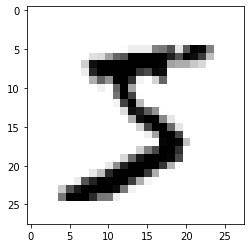

In [48]:
def imshow(tensor):
    plt.imshow(tensor.squeeze(), cmap='binary')
    plt.show()
    
imshow(train_set[0][0])

### Datasets loaders

In [0]:
# PARAMS
BATCH_SIZE = 64
TEST_BATCH_SIZE = 256

In [0]:
# Train set loader
train_set_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
# Test set loader
test_set_loader = data.DataLoader(test_set, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=4)

## Squashing functions

In [0]:
def squash(v):
    dot_prod = v.T @ v
    
    if dot_prod == 0:
        return torch.zeros_like(v)
    
    unit_v = v / torch.sqrt(dot_prod)
    squashing = dot_prod / (dot_prod+1)
    
    return squashing * unit_v

def squash_relu(v, eps=0.00):
    norm = v.norm()
    
    if norm == 0:
        return torch.zeros_like(v)
    
    unit_v = v / norm
    v = torch.tensor([
        a if a > 0 else eps*a for a in v
    ])
    squashing = v.norm()
    
    return squashing * unit_v

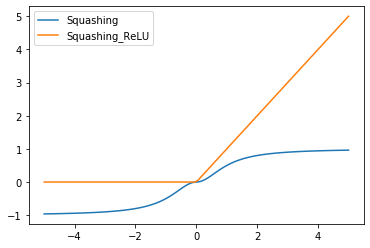

In [52]:
x = torch.linspace(-5, 5)

y = [squash(torch.tensor([v]))[0] for v in x]
y_relu = [squash_relu(torch.tensor([v]))[0] for v in x]

plt.plot(x, y);
plt.plot(x, y_relu);

plt.legend(['Squashing', 'Squashing_ReLU']);

## Convolutional Layer

In [0]:
class ConvLayer(nn.Module):
    '''A Convolutional Layer'''
    
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size)
        
    def forward(self, x):
        return F.relu(self.conv(x))

## Primary Capsules

In [0]:
class PrimaryCaps(nn.Module):
    '''Primary Capsules'''
    
    def __init__(self, num_capsules=32, in_channels=256, out_channels=8, kernel_size=9, stride=2):
        super(PrimaryCaps, self).__init__()
        
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size, stride) for _ in range(num_capsules)
        ])
    
    def forward(self, x):
        output = []
        
        for capsule in self.capsules:
            out = F.relu(capsule(x))
            output.append(out)
        
        output = torch.stack(output, dim=1)
        output = output.view(x.size(0), 32*6*6, 8)
        
        return self.activation(output)
    
    def activation(self, x, squash=squash):
        output = torch.zeros_like(x)
        
        for i in range(x.size(0)):
            for j in range(x.size(1)):
                output[i][j][:] = squash(x[i][j][:])
        
        return output

## Digit Capsules

In [0]:
class DigitCaps(nn.Module):
    '''Digit Capsules'''
    
    def __init__(self, num_capsules=10, num_inputs_per_capsule=32*6*6, in_dim=8, out_dim=16, r=3):
        super(DigitCaps, self).__init__()
        
        self.num_capsules = num_capsules
        self.num_inputs_per_capsule = num_inputs_per_capsule
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.r = r
        
        self.W = nn.Parameter(torch.randn(num_inputs_per_capsule, in_dim, out_dim, dtype=torch.float32))
    
    def routing(self, U_hat):
        b_ij = torch.zeros(self.num_inputs_per_capsule, self.num_capsules, dtype=torch.float32)
        if USE_CUDA and torch.cuda.is_available():
            b_ij = b_ij.to(torch.device('cuda'))
        else:
            b_ij = b_ij.to(torch.device('cpu'))

        v_j = None
        
        for iteration in range(self.r):
            c_ij = F.softmax(b_ij, dim=1)
            s_j = c_ij.T.unsqueeze(0) @ U_hat
            v_j = self.activation(s_j)
            
            if iteration < self.r-1:
                b_ij = b_ij + (U_hat @ v_j.view(-1, self.out_dim, self.num_capsules)).mean(dim=0)
            
        return v_j
        
    def forward(self, x):
        U_hat = []
        U_hat_i = []
        
        for u in x:
            for i in range(self.num_inputs_per_capsule):
                U_hat_i.append((self.W[i].T @ u[i]).unsqueeze(0))
            
            U_hat.append(torch.cat(U_hat_i).unsqueeze(0))
            U_hat_i = []
        
        U_hat = torch.cat(U_hat)
        
        return self.routing(U_hat)
    
    def activation(self, x, squash=squash):
        output = torch.zeros_like(x)
        
        for i in range(x.size(0)):
            for j in range(x.size(1)):
                output[i][j][:] = squash(x[i][j][:])
        
        return output

## Decoder

In [0]:
class Decoder(nn.Module):
    '''Capsule Net Decoder'''
    
    def __init__(self, in_dim=16, out_dim=28*28):
        super(Decoder, self).__init__()
        
        self.reconstruction_layers = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, out_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        most_active_idx = torch.norm(x, dim=2).argmax(dim=1)
        x_masked = torch.cat([x[i, idx].unsqueeze(0) for i, idx in zip(range(x.size(0)), most_active_idx)])
        
        return self.reconstruction_layers(x_masked)

# Capsule Network

In [0]:
class CapsNet(nn.Module):
    '''Capsule Network'''
    
    def __init__(self):
        super(CapsNet, self).__init__()
        
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = self.primary_capsules(x)
        x = self.digit_capsules(x)
        
        reconstruction = self.decoder(x)
        
        return x, reconstruction
    
    @staticmethod
    def loss(output, targets, reconstruction, images):
        return CapsNet.margin_loss(output, targets) + \
            CapsNet.reconstruction_loss(reconstruction, images)

    @staticmethod
    def margin_loss(output, targets, lmbd=0.5, m_plus=0.9, m_minus=0.1):
        probs = torch.norm(output, dim=2)
        left = F.relu(m_plus - probs)**2
        right = F.relu(probs - m_minus)**2

        most_active_idx = probs.argmax(dim=1)
        T = (most_active_idx == targets).int().unsqueeze(1)
        loss = T * left + lmbd*(1 - T) * right
        
        return loss.sum()
    
    @staticmethod
    def reconstruction_loss(reconstruction, images, criterion=nn.MSELoss()):
        return criterion(reconstruction, images.view(reconstruction.size(0), -1))

# Train

In [0]:
EPOCHS = 5

capsnet = CapsNet()
optimizer = optim.Adam(capsnet.parameters(), lr=0.001)

if USE_CUDA and torch.cuda.is_available():
    print('USING CUDA')
    capsnet = capsnet.to(torch.device('cuda'))
else:
    print('USING CPU')
    capsnet = capsnet.to(torch.device('cpu'))


for epoch in range(1, EPOCHS+1):
    
    print('='*10, 'TRAIN', '='*10)
    capsnet.train()
    running_loss = 0.0
    
    for i, batch in enumerate(train_set_loader, 1):
        optimizer.zero_grad()
        
        # Load the batch
        images, targets = batch
        if USE_CUDA and torch.cuda.is_available():
            images = images.to(torch.device('cuda'))
            targets = targets.to(torch.device('cuda'))
        
        # Forward
        output, reconstruction = capsnet(images)
        # Compute loss
        loss = CapsNet.loss(output, targets, reconstruction, images)
        # Backward
        loss.backward()
        # Optim step
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1 == 0:
            print(f'==> EPOCH[{epoch}] ({i}/{len(train_set_loader)}): LOSS: {loss.item()}')
    print(f'=====> EPOCH[{epoch}] Completed: Avg. LOSS: {running_loss/len(train_set_loader)}')
    
    print('='*10, 'EVAL', '='*10)
    capsnet.eval()
    running_accuracy = 0.0
    
    for i, batch in enumerate(test_set_loader, 1):

        # Load the batch
        images, targets = batch
        if USE_CUDA and torc.cuda.is_available():
            images = images.to(torch.device('cuda'))
            targets = targets.to(torch.device('cuda'))
        
        with torch.no_grad():
            # Forward
            output, reconstruction = capsnet(images)
            most_active_idx = output.norm(dim=2).argmax(dim=1)
            running_accuracy += torch.sum((most_active_idx == targets)) / targets.size(0)

    print(f'=====> EPOCH[{epoch}]: ACCURACY: {running_accuracy/len(test_set_loader)}')

USING CUDA
========== TRAIN ==========
==> EPOCH[1] (1/938): LOSS: 111.05752563476562
==> EPOCH[1] (2/938): LOSS: 247.0171661376953
==> EPOCH[1] (3/938): LOSS: 234.89208984375
==> EPOCH[1] (4/938): LOSS: 238.92877197265625
==> EPOCH[1] (5/938): LOSS: 218.6754608154297
==> EPOCH[1] (6/938): LOSS: 238.88478088378906
==> EPOCH[1] (7/938): LOSS: 230.77041625976562
==> EPOCH[1] (8/938): LOSS: 230.74557495117188
==> EPOCH[1] (9/938): LOSS: 226.6778564453125
==> EPOCH[1] (10/938): LOSS: 222.62191772460938
==> EPOCH[1] (11/938): LOSS: 238.79397583007812
